# Visualisations of the Tracked Regional European Events (OSTIA Observations) using `plotX`
cf. Plots when exchange for Basic Tracking (i.e. `extreme_events_basic_regional.zarr`)

In [1]:
from getpass import getuser
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Video

import marEx
import marEx.helper as hpc

In [2]:
# Directories
scratch_dir = Path("/scratch") / getuser()[0] / getuser()  # Lustre Scratch Directory

file_name_extremes = scratch_dir / "mhws" / "extremes_binary_regional_shifting_hobday.zarr"
file_name_events = scratch_dir / "mhws" / "extreme_events_merged_regional_shifting.zarr"
plot_dir = scratch_dir / "mhws" / "plots"

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=32, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

In [4]:
# Import Tracked Extremes DataSet
extremes_ds = xr.open_zarr(str(file_name_extremes), chunks={})
extremes_ds

<xarray.Dataset> Size: 50GB
Dimensions:         (time: 9282, lat: 800, lon: 1300, dayofyear: 366)
Coordinates:
  * dayofyear       (dayofyear) int32 1kB 1 2 3 4 5 6 ... 362 363 364 365 366
  * lat             (lat) float32 3kB 30.02 30.08 30.12 ... 69.88 69.93 69.97
  * lon             (lon) float32 5kB -19.98 -19.92 -19.88 ... 44.88 44.92 44.97
  * time            (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-0...
Data variables:
    dat_anomaly     (time, lat, lon) float32 39GB dask.array<chunksize=(25, 800, 1300), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 10GB dask.array<chunksize=(25, 800, 1300), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(400, 650), meta=np.ndarray>
    thresholds      (lat, lon, dayofyear) float32 2GB dask.array<chunksize=(100, 163, 46), meta=np.ndarray>
Attributes:
    max_anomaly:           5.0
    method_anomaly:        shifting_baseline
    method_extreme:        hobday_extreme
    method_percentile:     approximate
    precision:             0.01
    preprocessing_steps:   ['Rolling climatology using 15 years', 'Smoothed w...
    smooth_days_baseline:  21
    threshold_percentile:  95
    window_days_hobday:    11
    window_year_baseline:  15

In [5]:
# Import Tracked Events DataSet
extreme_events_ds = xr.open_zarr(str(file_name_events), chunks={})
extreme_events_ds

<xarray.Dataset> Size: 42GB
Dimensions:       (ID: 4564, time: 9282, lat: 800, lon: 1300, component: 2,
                   sibling_ID: 15)
Coordinates:
  * ID            (ID) int32 18kB 1 2 3 4 5 6 ... 4559 4560 4561 4562 4563 4564
  * component     (component) int64 16B 0 1
  * lat           (lat) float32 3kB 30.02 30.08 30.12 ... 69.88 69.93 69.97
  * lon           (lon) float32 5kB -19.98 -19.92 -19.88 ... 44.88 44.92 44.97
  * time          (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-...
Dimensions without coordinates: sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 39GB dask.array<chunksize=(1, 800, 1300), meta=np.ndarray>
    area          (time, ID) float32 169MB dask.array<chunksize=(1, 4564), meta=np.ndarray>
    centroid      (component, time, ID) float32 339MB dask.array<chunksize=(1, 1, 4564), meta=np.ndarray>
    global_ID     (time, ID) int32 169MB dask.array<chunksize=(1, 4564), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 3GB dask.array<chunksize=(1, 4564, 15), meta=np.ndarray>
    presence      (time, ID) bool 42MB dask.array<chunksize=(1, 4564), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 37kB dask.array<chunksize=(4564,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 37kB dask.array<chunksize=(4564,), meta=np.ndarray>
Attributes: (12/14)
    N_events_final:              4564
    N_objects_filtered:          34597
    N_objects_prefiltered:       40405
    R_fill:                      16
    T_fill:                      4
    accepted_area_fraction:      0.997835095576814
    ...                          ...
    area_threshold (cells):      600
    multi_parent_merges:         3121
    nn_partitioning:             1
    overlap_threshold:           0.25
    preprocessed_area_fraction:  0.7047647269550515
    total_merges:                7360

In [6]:
# Extract the Events ID Field
ID_field = extreme_events_ds.ID_field
ID_field

<xarray.DataArray 'ID_field' (time: 9282, lat: 800, lon: 1300)> Size: 39GB
dask.array<open_dataset-ID_field, shape=(9282, 800, 1300), dtype=int32, chunksize=(1, 800, 1300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 30.02 30.08 30.12 30.17 ... 69.88 69.93 69.97
  * lon      (lon) float32 5kB -19.98 -19.92 -19.88 -19.83 ... 44.88 44.92 44.97
  * time     (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-31T12...

## Make a Movie using `plotX.animate`
N.B.: Making `dask`-powered movies using `animate()` cannot be threaded !

In [ ]:
# Choose a subset of the ID field
extreme_events_ds_subset = extreme_events_ds.sel(time=slice("2020-01-01", "2022-05-31"))
ID_field_subset = extreme_events_ds_subset.ID_field
centroids_subset = extreme_events_ds_subset.centroid

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
ID_field_subset.plotX.animate(
    config,
    plot_dir=plot_dir,
    file_name="movie_ID_field_regional",
    centroids=centroids_subset
)

In [7]:
Video("../../media/movie_ID_field_regional.mp4", width=640, height=480, embed=False)

In [ ]:
# Plot the anomalous temperature field

anomaly_subset = extremes_ds.dat_anomaly.sel(time=slice("2020-01-01", "2022-05-31"))
anomaly_hot = anomaly_subset.where(anomaly_subset > 0, 0)

extreme_events_ds_subset = extreme_events_ds.sel(time=slice("2020-01-01", "2022-05-31"))
ID_field_subset = extreme_events_ds_subset.ID_field
centroids_subset = extreme_events_ds_subset.centroid

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(var_units="Temperature Anomaly", cmap="inferno", cperc=[0, 98], projection=ccrs.PlateCarree())
anomaly_hot.plotX.animate(
    config,
    plot_dir=plot_dir,
    file_name="movie_anomaly_regional",
    centroids=centroids_subset,
    object_ids=ID_field_subset
)

In [9]:
Video("../../media/movie_anomaly_regional.mp4", width=640, height=480, embed=False)

cf. "Basic" Tracking, i.e. the current standard method in the literature, involving _No_ temporal gap filling, _No_ merging/splitting and _No_ independent event tracking.

In [ ]:
# Choose a subset of the "Basic" ID field
ID_field_basic_subset = xr.open_zarr(str(file_name_events).replace("merged", "basic"), chunks={}).ID_field.sel(
    time=slice("2020-01-01", "2022-05-31")
)

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
ID_field_basic_subset.plotX.animate(config, plot_dir=plot_dir, file_name="movie_ID_field_basic_regional")

In [10]:
Video("../../media/movie_ID_field_basic_regional.mp4", width=640, height=480, embed=False)

## Plot Consecutive Days of Extreme Events

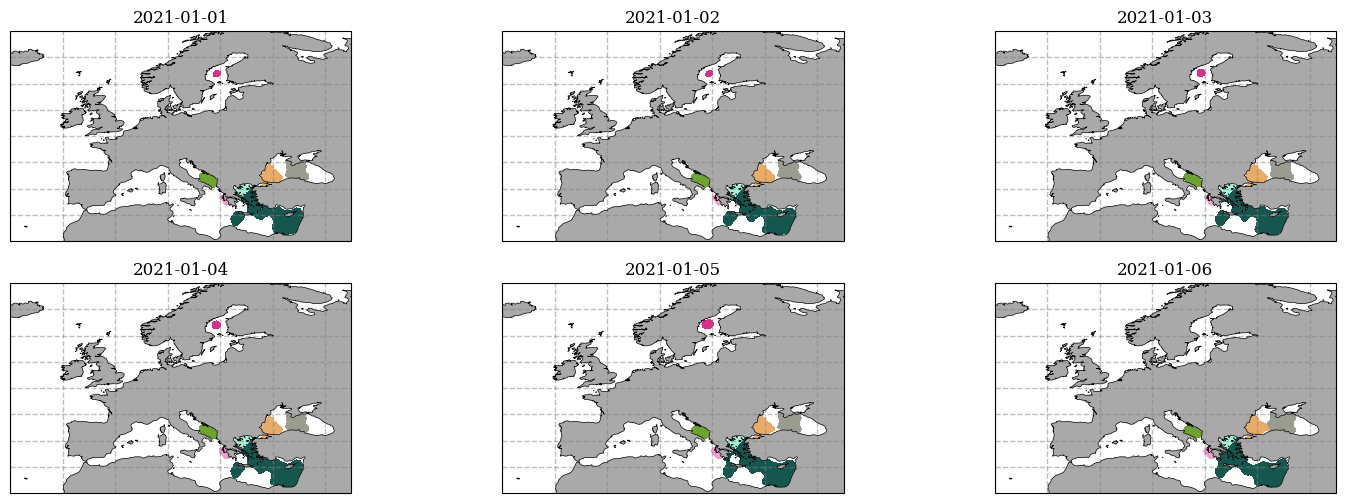

In [13]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2021-01-01", "2021-01-06"))

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
fig, ax = ID_field_subset.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Regional Extreme Event Frequency

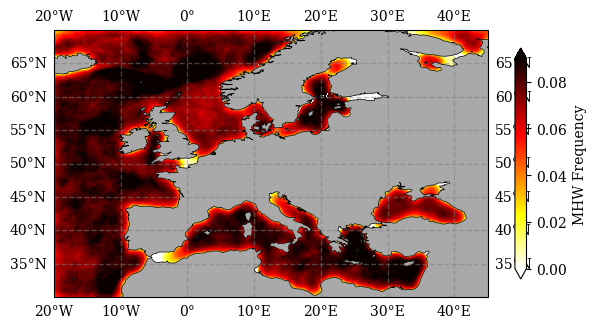

In [14]:
# Calculate the frequency of Event Occurrence
event_frequency = (ID_field > 0).mean("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())
fig, ax, im = event_frequency.plotX.single_plot(config)

## Plot Seasonal Extreme Event Frequency

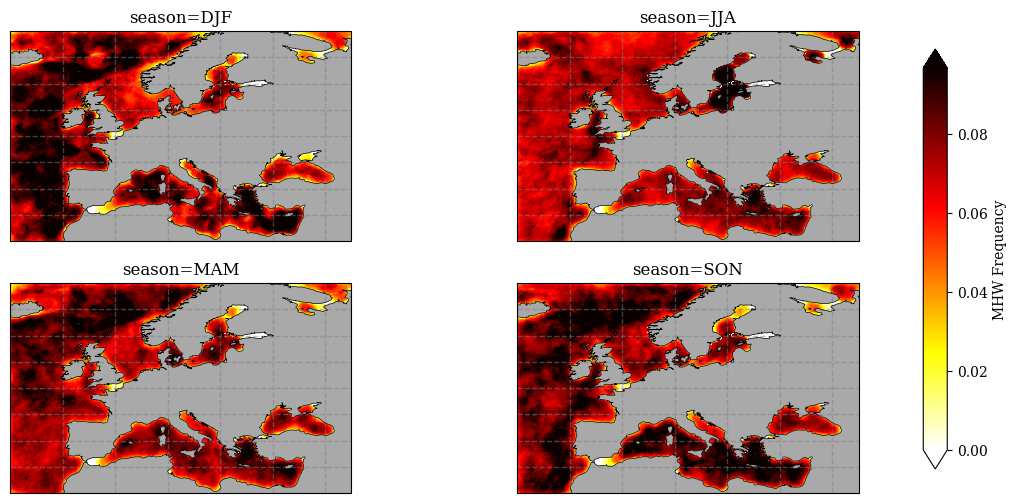

In [15]:
# Calculate the frequency of Event Occurrence per season
seasonal_frequency = (ID_field > 0).groupby("time.season").mean(dim="time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())
fig, ax = seasonal_frequency.plotX.multi_plot(config, col="season", col_wrap=2);

## Find & Plot a Few of the Longest Regional Events

In [16]:
events_duration = extreme_events_ds.time_end - extreme_events_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(
        f"ID: {ID:<6}   Start Day: {extreme_events_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days"
    )

ID: 148      Start Day: 1997-09-22  -->  Duration: 198  days
ID: 146      Start Day: 1997-09-18  -->  Duration: 196  days
ID: 150      Start Day: 1997-09-29  -->  Duration: 192  days
ID: 1413     Start Day: 2004-01-10  -->  Duration: 186  days
ID: 1180     Start Day: 2002-11-25  -->  Duration: 185  days
ID: 3546     Start Day: 2016-02-28  -->  Duration: 184  days
ID: 1174     Start Day: 2002-11-19  -->  Duration: 180  days
ID: 4296     Start Day: 2020-09-05  -->  Duration: 176  days
ID: 1185     Start Day: 2002-12-03  -->  Duration: 175  days
ID: 324      Start Day: 1998-09-17  -->  Duration: 174  days


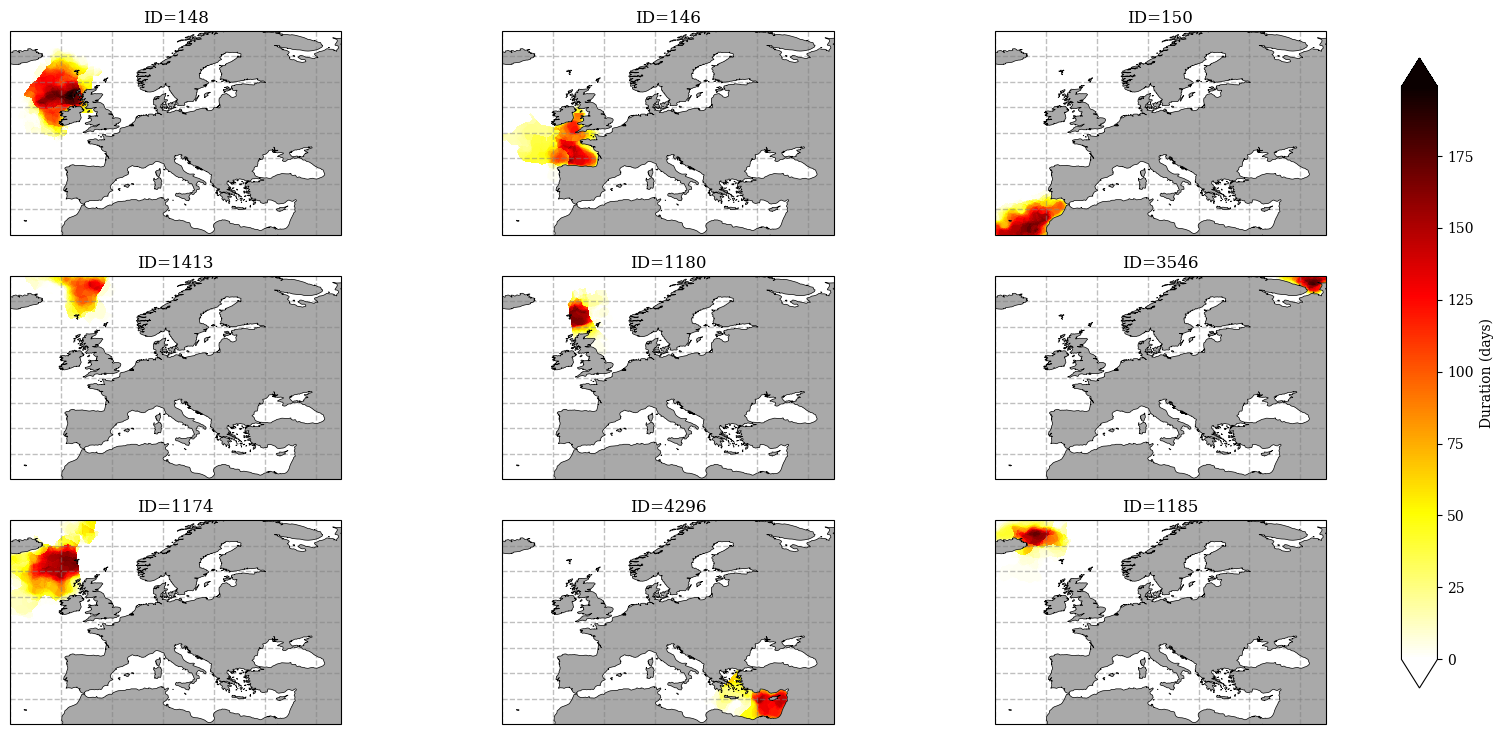

In [17]:
# Calculate the local duration of the longest events
long_events = ID_field == (longest_events[:9]).chunk({"ID": 1})
long_events_local_duration = (long_events > 0).sum("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="Duration (days)", cmap="hot_r", cperc=[0, 100], projection=ccrs.PlateCarree())
fig, ax = long_events_local_duration.plotX.multi_plot(config, col="ID", col_wrap=3);

## ID Maximum and Mean Event Area

In [19]:
areas_max = extreme_events_ds.area.max().compute()
print(f"Maximum object area: {areas_max.values:.0f} km²")

areas_mean = extreme_events_ds.area.mean().compute()
print(f"Mean object area: {areas_mean.values:.0f} km²")

Maximum object area: 1820358 km²
Mean object area: 137291 km²
